In [74]:
import pyvisa as pv
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio   
import pickle
import scipy.signal
from tqdm.notebook import tqdm, trange
from scipy.special import erfc
import scipy as sp
from optic.comm.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample, decimate,clockSamplingInterp,symbolSync
from optic.comm.metrics import signal_power,fastBERcalc
from optic.dsp.equalization import *
from optic.plot import eyediagram
plt.rcParams["figure.figsize"] = (12,6)

from funcoesLab import *

In [69]:
def zero_to_nan(values):
    return [float('nan') if x==0 else x for x in values]

nsimbolos = 1e5
M = 4
SPS= 2
formatoPulso = 'rrc'
nTaps = 2048
alpha = 0.01
plotlim = 20
bits = np.random.randint(0,2,int(nsimbolos*np.log2(M)))
    
simbolos = modulateGray(bits, M, 'pam')
simbolos = pnorm(simbolos)

# Fomartação de pulso
simbolosup = upsample(simbolos, SPS)

pulso = pulseShape(formatoPulso, SPS, nTaps, alpha)
pulso = pulso/max(abs(pulso))

transmitido = pnorm(firFilter(pulso, simbolosup))
transmitido = transmitido.real



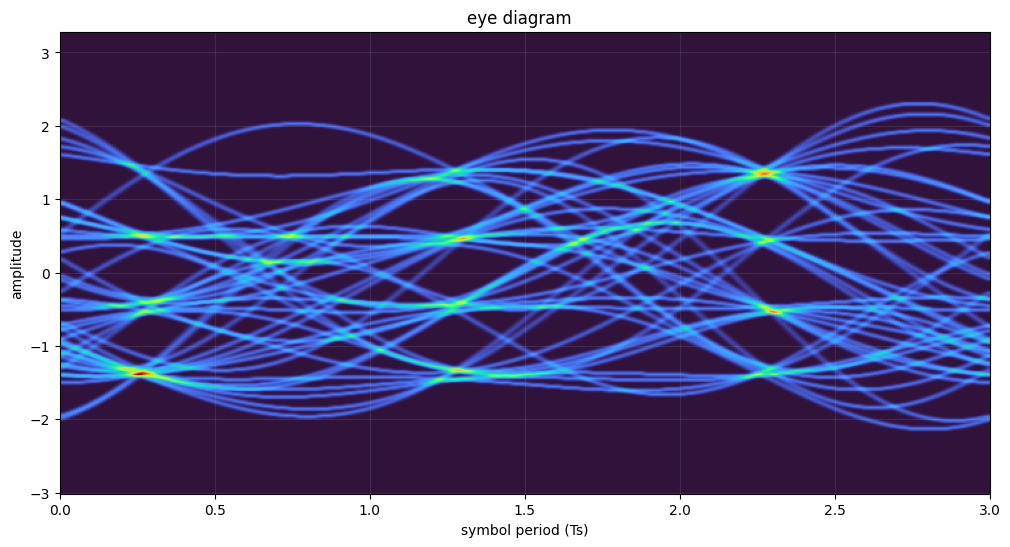

<StemContainer object of 3 artists>

<Figure size 1200x600 with 0 Axes>

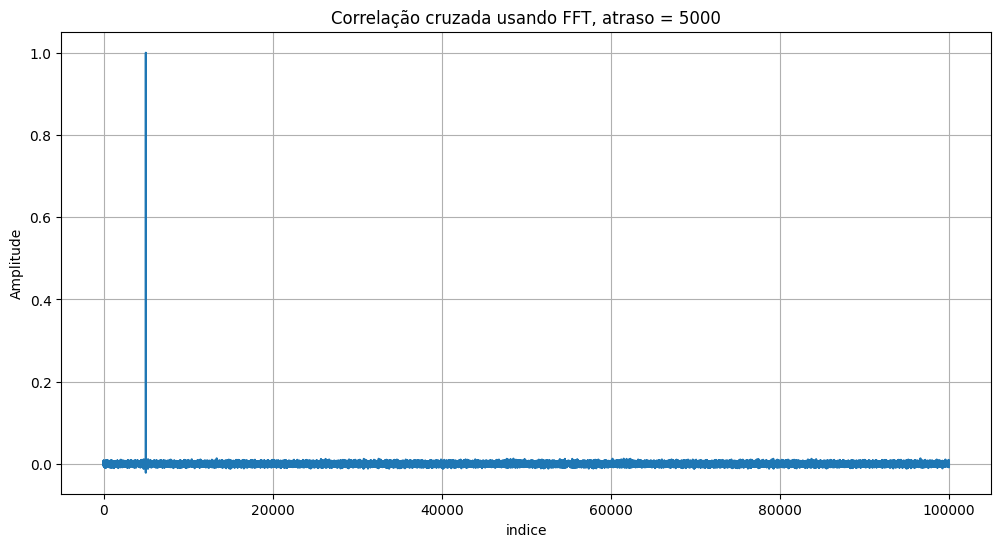

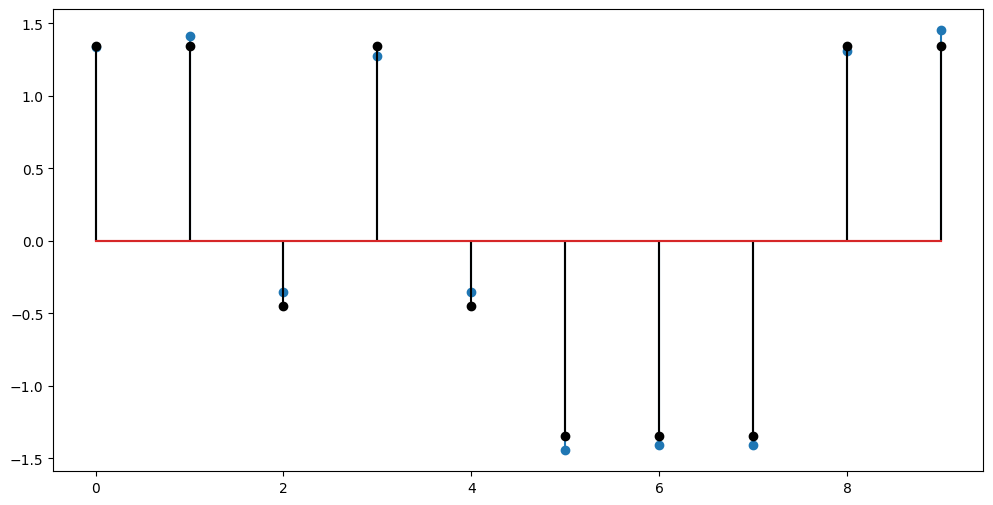

In [125]:
from optic.utils import parameters
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample, decimate,clockSamplingInterp

def periodic_corr(x, y):
    ##############################################################
    # Função para calcular a correlação periodica entre dois arrays usando a FFT
    # Usada para calcular o atraso do sinal recebido.
    # Parametros:
    # x,y (array numpy): Arrays para calcular a correlação
    # Output:
    # Array da correlação dos dois sinais, para calcular o indice do atraso, bastar usar np.argmax()
    ##############################################################
    
    return (ifft(fft(x) * fft(y).conj()).real)

def sicronizarSinais(y,x,plot=False):

    if len(x) > len(y):
        y = np.append(y,np.zeros(len(x)-len(y)))
    if len(y) > len(x):
        x = np.append(x,np.zeros(len(y)-len(x)))
    corr = periodic_corr(pnorm(x-np.mean(x)), pnorm(y-np.mean(y)))
    delay = np.argmax(corr)
    if plot == True:
        plt.figure()
        plt.plot(corr/np.max(corr))
        plt.xlabel('indice')
        plt.ylabel('Amplitude')
        plt.grid()
        plt.title(f'Correlação cruzada usando FFT, atraso = {int(delay)}')
    return np.roll(y,delay)


recebido = clockSamplingInterp(transmitido.reshape(-1,1),Fs_in=SPS,Fs_out=SPS*10,jitter_rms=0)[:,0]
#recebido = np.append(recebido,recebido[0:len(recebido)//2])
recebido = np.roll(recebido,-100000)

#
pulso = pulseShape(formatoPulso, SPS*10, nTaps, alpha)
pulso = pulso/max(abs(pulso))
recebidocasado = pnorm(firFilter(pulso,recebido))
eyediagram(recebidocasado,len(recebidocasado),SPS*10,ptype='fancy')

plt.figure(2)
paramDec = parameters()
paramDec.SpS_in  = SPS*10
paramDec.SpS_out = 1
recebidodecimado = decimate(recebidocasado, paramDec)
recebidodecimado=recebidodecimado[:,0]
recebidodecimado = sicronizarSinais(pnorm(recebidodecimado),pnorm(simbolos),plot=True)
#recebidodecimado = symbolSync(recebidodecimado.reshape(-1,1),simbolos.reshape(-1,1),1)

# recebidodecimado = clockSamplingInterp(sinalcasado.reshape(-1,1),Fs_in=SPS,Fs_out=1,jitter_rms=0)[:,0]
# recebidodecimado = sinalcasado[1::SPS]
plt.figure()
plt.stem(pnorm(recebidodecimado)[0:10])
plt.stem(pnorm(simbolos)[0:10],'k')

# plt.figure(3)
# plt.psd(sinal,Fs=SPS, NFFT = 1024, sides='twosided', label = 'Transmitido')
# plt.psd(sinalcasado,Fs=SPS, NFFT = 1024, sides='twosided', label = 'Transmitido')
# fastBERcalc(recebidodecimado,simbolos,4,'pam')

In [78]:
sinal.reshape(-1,1).shape

(200000, 1)

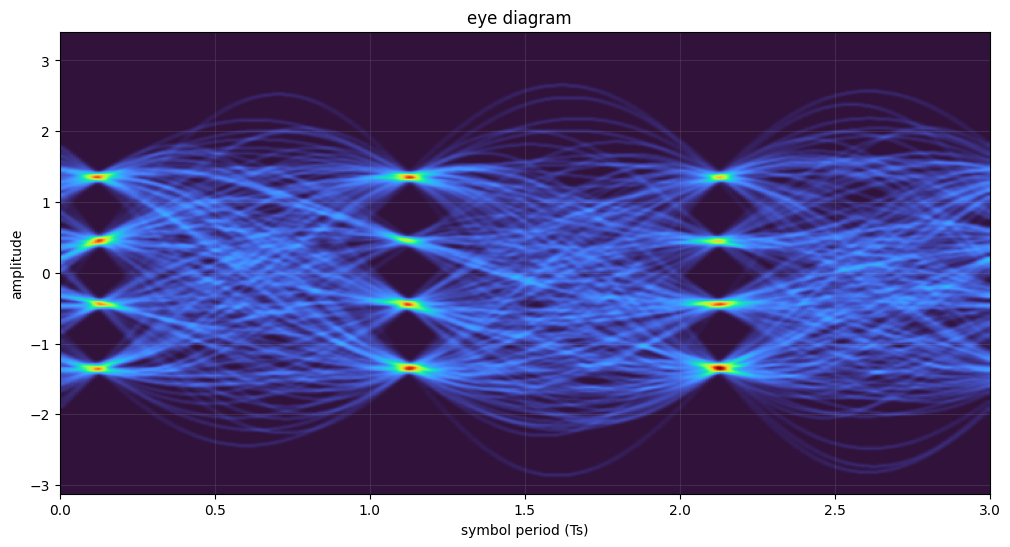

<Figure size 1200x600 with 0 Axes>

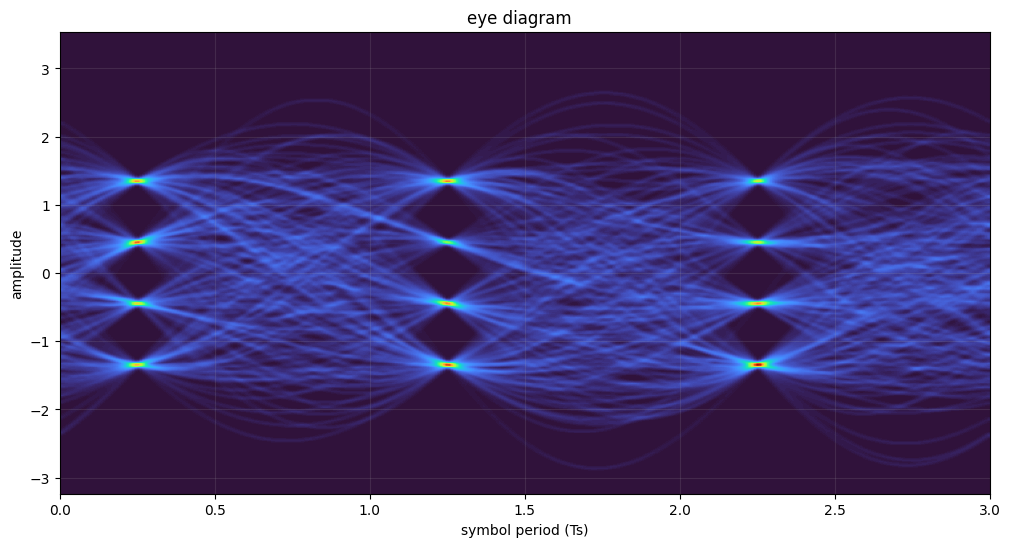

In [43]:
# ruído gaussiano branco
Namostras = sinal.size
σ2  = 0.0090 # variância
μ   = 0      # média

σ      = np.sqrt(σ2*SPS) 
ruido  = np.random.normal(μ, σ, Namostras)
ruido = 0 
eyediagram(pnorm(sinal)+ruido,len(sinal),SPS,ptype='fancy')
plt.figure(2)
eyediagram(pnorm(sinalcasado),len(sinal),SPS,ptype='fancy')
